In [1]:
import torch
import numpy as np
import tensorflow as tf
from transformers import AutoModel, AutoTokenizer
from sklearn.metrics import classification_report, confusion_matrix
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import os

In [2]:
audio_classifier = tf.keras.models.load_model("/kaggle/input/unber-1k/Autoencoder_UNBER/Autoencoder_UNBER/AEclassifier.keras")
audio_encoder = tf.keras.models.load_model("/kaggle/input/unber-1k/Autoencoder_UNBER/Autoencoder_UNBER/AEencoder.keras")

In [3]:
text_model = AutoModel.from_pretrained("/kaggle/input/unber-1k/ReelBBert-20250215T144010Z-001/ReelBBert")
text_tokenizer = AutoTokenizer.from_pretrained("/kaggle/input/unber-1k/ReelBBert-20250215T144010Z-001/ReelBBert")

In [4]:
from transformers import ViTForImageClassification

video_model = ViTForImageClassification.from_pretrained("/kaggle/input/unber-1k/ViT-UNBER/ViT-UNBER")
video_model.eval()

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [5]:
feature_dim = 256
hidden_dim = 128
num_heads = 4
num_classes = 4

In [6]:
# def extract_audio_features(audio_input):
#     audio_encoded = audio_encoder.predict(audio_input)
#     return torch.tensor(audio_encoded, dtype=torch.float32)

In [7]:
def extract_audio_features_batched(audio_input, batch_size=16):
    all_features = []

    for i in range(0, len(audio_input), batch_size):
        batch_audio = audio_input[i : i + batch_size]  # Get a batch

        # Predict features in small batches
        batch_encoded = audio_encoder.predict(batch_audio)

        # Convert to PyTorch tensor and move to CPU to free GPU memory
        batch_tensor = torch.tensor(batch_encoded, dtype=torch.float32).cpu()
        all_features.append(batch_tensor)

    return torch.cat(all_features, dim=0)

In [8]:
# def extract_text_features(text_input):
#     inputs = text_tokenizer(text_input, return_tensors="pt", padding=True, truncation=True, max_length=512)
#     with torch.no_grad():
#         text_embeds = text_model(**inputs).last_hidden_state[:, 0, :]
#     return text_embeds

In [9]:
def extract_text_features_batched(text_inputs, batch_size=16):
    all_features = []

    for i in range(0, len(text_inputs), batch_size):
        batch_texts = text_inputs[i : i + batch_size]

        # Tokenize batch
        inputs = text_tokenizer(batch_texts, return_tensors="pt", padding=True, truncation=True, max_length=512)

        with torch.no_grad():
            text_embeds = text_model(**inputs).last_hidden_state[:, 0, :]  # CLS token representation

        all_features.append(text_embeds.cpu())  # Move to CPU to free GPU memory

    return torch.cat(all_features, dim=0)

In [10]:
# def extract_video_features(video_input):
#     # Convert NumPy array to PyTorch tensor
#     video_tensor = torch.tensor(video_input, dtype=torch.float32)

#     # If using GPU, move to CUDA
#     if torch.cuda.is_available():
#         video_tensor = video_tensor.cuda()
#         video_model.cuda()

#     with torch.no_grad():
#         video_embeds = video_model(video_tensor)

In [11]:
def extract_video_features_batched(video_input, batch_size=16):
    all_features = []

    # Convert NumPy array to PyTorch tensor
    video_tensor = torch.tensor(video_input, dtype=torch.float32)

    # Ensure proper shape (Batch, 3, Height, Width) if needed
    if video_tensor.ndim == 3:  # (H, W, C) -> (1, C, H, W)
        video_tensor = video_tensor.permute(2, 0, 1).unsqueeze(0)
    elif video_tensor.ndim == 4 and video_tensor.shape[-1] == 3:  # (Batch, H, W, C) -> (Batch, C, H, W)
        video_tensor = video_tensor.permute(0, 3, 1, 2)

    # Move tensor to GPU if available
    if torch.cuda.is_available():
        video_tensor = video_tensor.cuda()
        video_model.cuda()

    # Process in batches to avoid memory issues
    for i in range(0, len(video_tensor), batch_size):
        batch_video = video_tensor[i : i + batch_size]

        with torch.no_grad():
            video_embeds = video_model(batch_video)  # Get video features

        # Access the feature embeddings (logits) and move to CPU
        video_embeds = video_embeds.logits if hasattr(video_embeds, 'logits') else video_embeds
        all_features.append(video_embeds.cpu())  # Move to CPU after each batch

    return torch.cat(all_features, dim=0)

In [12]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [13]:
VIDEO_PATH = "/kaggle/input/unber-1k/test/test/test_frames"  # Path for video frames
AUDIO_PATH = "/kaggle/input/unber-1k/test/test/test_audios"  # Path for audio files
TEXT_CSV = "/kaggle/input/unber-1k/test/test/test.csv"

In [14]:
import pandas as pd
tdf = pd.read_csv(TEXT_CSV)

In [15]:
tdf['Visual texts'] = tdf['Visual texts'].fillna("কোন টেক্সট পাওয়া যায়নি")

In [16]:
tdf.head()

,reel_id,UnsafeType,Visual texts
0,www.facebook.com/reel/1211216493497701,Safe,হারাই ফেলছো তুমি সেই মানুষটাকে যে কিনা সারাদিন...
1,www.facebook.com/reel/1250600472816174,Safe,I NEED WEEKEND\nThe Talking Bro
2,www.facebook.com/reel/1674327546697237,Safe,কোন টেক্সট পাওয়া যায়নি
3,www.facebook.com/reel/527148616749949,Safe,কোন টেক্সট পাওয়া যায়নি
4,www.facebook.com/reel/9237254386306054,Safe,বয়স্ক পিচ্চি মানুষ চা খাবে নাকি অন্য কিছুর মজা...


In [17]:
tdf['UnsafeType'].value_counts()

UnsafeType
Safe        150
Adult       120
Harmful     120
Suicidal    110
Name: count, dtype: int64

In [18]:
tdf['UnsafeType'], uniques = pd.factorize(tdf['UnsafeType'])
uniques

Index(['Safe', 'Adult', 'Harmful', 'Suicidal'], dtype='object')

In [19]:
pip install noisereduce

Note: you may need to restart the kernel to use updated packages.


In [20]:
import os
import numpy as np
import pandas as pd
import librosa
import noisereduce as nr
import soundfile as sf

In [21]:
IMG_SIZE = (224, 224)
NUM_CLASSES = 4

In [22]:
def load_video_frames(folder_path):
    frames = []
    frame_files = sorted(os.listdir(video_folder))
    for file in frame_files:
        img_path = os.path.join(video_folder, file)
        img = load_img(img_path, target_size=IMG_SIZE)
        img = img_to_array(img)
        frames.append(img)

    return np.array(frames)

In [23]:
def process_audio_file(file_path, target_length=5, sample_rate=22050, n_mfcc=13, n_chroma=12, n_spectral_contrast=6, target_length_features=20):
    # Load audio file
    audio, sr = librosa.load(file_path, sr=sample_rate)

    # Trim or pad audio to target length
    target_samples = target_length * sr
    if len(audio) > target_samples:
        audio = audio[:target_samples]  # Trim
    else:
        padding = target_samples - len(audio)
        audio = np.pad(audio, (0, padding), mode='constant')  # Pad with silence

    # Normalize audio (zero mean, unit variance)
    mean = np.mean(audio)
    std = np.std(audio)
    safe_std = max(std, 1e-8)  # Avoid division by zero
    audio = (audio - mean) / safe_std

    # Apply noise reduction
    reduced_noise_audio = nr.reduce_noise(y=audio, sr=sr)

    if not np.isfinite(reduced_noise_audio).all():
        print("Warning: Noise reduction produced NaN/Inf values, reverting to original audio.")
        reduced_noise_audio = audio  # Use original if noise reduction fails
    
    reduced_noise_audio = np.nan_to_num(reduced_noise_audio)

    # Feature Extraction
    def truncate_or_pad(feature, target_length_features):
        """Ensures features have a fixed length by truncating or padding."""
        if feature.shape[1] > target_length_features:
            return feature[:, :target_length_features]
        else:
            return np.pad(feature, ((0, 0), (0, target_length_features - feature.shape[1])), mode='constant')

    # Extract MFCCs (13 coefficients)
    mfcc = librosa.feature.mfcc(y=reduced_noise_audio, sr=sr, n_mfcc=n_mfcc)
    mfcc = truncate_or_pad(mfcc, target_length_features)

    # Extract Chroma Features (12 pitch classes)
    chroma = librosa.feature.chroma_stft(y=reduced_noise_audio, sr=sr, n_chroma=n_chroma)
    chroma = truncate_or_pad(chroma, target_length_features)

    # Extract Spectral Centroid
    spectral_centroid = librosa.feature.spectral_centroid(y=reduced_noise_audio, sr=sr)
    spectral_centroid = truncate_or_pad(spectral_centroid, target_length_features)

    # Extract Spectral Contrast (6 bands)
    spectral_contrast = librosa.feature.spectral_contrast(y=reduced_noise_audio, sr=sr, n_bands=n_spectral_contrast)
    spectral_contrast = truncate_or_pad(spectral_contrast, target_length_features)

    # Extract Spectrogram (Magnitude Spectrogram)
    spectrogram = np.abs(librosa.stft(reduced_noise_audio))
    spectrogram = truncate_or_pad(spectrogram, target_length_features)

    # Flatten all features into a single vector
    feature_vector = np.concatenate([
        mfcc.flatten(),
        chroma.flatten(),
        spectral_centroid.flatten(),
        spectral_contrast.flatten(),
        spectrogram.flatten()
    ])

    return feature_vector

In [24]:
X_video, X_audio, X_text, y = [], [], [], []

In [25]:
for _, row in tdf.iterrows():
    reel_id = row["reel_id"].split("/")[-1]  
    label = row["UnsafeType"]  

    video_folder = os.path.join(VIDEO_PATH, reel_id)
    audio_file = os.path.join(AUDIO_PATH, f"audio{reel_id}.wav")

    if os.path.isdir(video_folder) and os.path.exists(audio_file):
        frames = load_video_frames(video_folder)  
        processed_audio = process_audio_file(audio_file)  
        text_feature = row["Visual texts"]  

        X_video.append(frames)
        X_audio.append(processed_audio)
        X_text.append(text_feature)
        y.append(label)

/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: divide by zero encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/noisereduce/spectralgate/nonstationary.py:70: RuntimeWarning: invalid value encountered in divide
  sig_mult_above_thresh = (abs_sig_stft - sig_stft_smooth) / sig_stft_smooth
/usr/local/lib/python3.10/dist-packages/librosa/core/pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [26]:
print(len(X_video), len(X_audio), len(X_text), len(y))

500 500 500 500


In [27]:
X_video = np.array(X_video) 
X_audio = np.array(X_audio, dtype=np.float32)
X_text = np.array(X_text)  
y = np.array(y)

In [28]:
X_video.shape

(500, 5, 224, 224, 3)

In [31]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Scale X_video, X_audio, and X_text
X_video_scaled = scaler.fit_transform(X_video.reshape(X_video.shape[0], -1))  # Flatten video frames
X_audio_scaled = scaler.fit_transform(X_audio.reshape(X_audio.shape[0], -1))  # Flatten audio features

In [32]:
X_video = X_video.reshape(-1, 224, 224, 3)
X_audio = np.repeat(X_audio, 5, axis=0)
X_text = np.repeat(X_text, 5, axis=0)
y = np.repeat(y, 5, axis=0)

In [33]:
X_video.shape

(2500, 224, 224, 3)

In [34]:
X_audio.shape 

(2500, 21160)

In [35]:
X_audio = np.expand_dims(X_audio, axis=-1)

In [36]:
X_audio.shape

(2500, 21160, 1)

In [37]:
X_text = X_text.tolist()

In [38]:
audio_feats = extract_audio_features_batched(X_audio, batch_size=16)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━

In [39]:
text_feats = extract_text_features_batched(X_text, batch_size=16)

In [40]:
video_feats = extract_video_features_batched(X_video, batch_size=16)

In [41]:
print(f"audio_feats shape: {audio_feats.shape}")
print(f"video_feats shape: {video_feats.shape}")
print(f"text_feats shape: {text_feats.shape}")

audio_feats shape: torch.Size([2500, 32])
video_feats shape: torch.Size([2500, 4])
text_feats shape: torch.Size([2500, 768])


In [42]:
audio_feats = torch.tensor(audio_feats, dtype=torch.float32)
video_feats = torch.tensor(video_feats, dtype=torch.float32)
text_feats = torch.tensor(text_feats, dtype=torch.float32)

<ipython-input-42-74623bb84699>:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  audio_feats = torch.tensor(audio_feats, dtype=torch.float32)
<ipython-input-42-74623bb84699>:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  video_feats = torch.tensor(video_feats, dtype=torch.float32)
<ipython-input-42-74623bb84699>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  text_feats = torch.tensor(text_feats, dtype=torch.float32)


In [43]:
class CrossModalAttentionFusion(nn.Module):
    def __init__(self):
        super(CrossModalAttentionFusion, self).__init__()

        # Projection layers for each modality (audio, video, text)
        self.audio_fc = nn.Linear(32, 256)   # Project audio to 256 dimensions
        self.video_fc = nn.Linear(4, 256)    # Project video to 256 dimensions
        self.text_fc = nn.Linear(768, 256)   # Project text to 256 dimensions

        # Final fusion layer to classify
        self.fusion_fc = nn.Linear(256 * 3, 4)  # Concatenate all features and output 4 classes

    def forward(self, audio_feats, video_feats, text_feats):
        # Apply the projection layers
        audio_feats_proj = self.audio_fc(audio_feats)
        video_feats_proj = self.video_fc(video_feats)
        text_feats_proj = self.text_fc(text_feats)

        # Concatenate all projected features
        fused_feats = torch.cat([audio_feats_proj, video_feats_proj, text_feats_proj], dim=1)

        # Final output (after fusion)
        output = self.fusion_fc(fused_feats)
        return output

In [44]:
fusion_model = CrossModalAttentionFusion()

In [45]:
fusion_model.eval()

CrossModalAttentionFusion(
  (audio_fc): Linear(in_features=32, out_features=256, bias=True)
  (video_fc): Linear(in_features=4, out_features=256, bias=True)
  (text_fc): Linear(in_features=768, out_features=256, bias=True)
  (fusion_fc): Linear(in_features=768, out_features=4, bias=True)
)

In [46]:
with torch.no_grad():
    # Forward pass through the fusion model
    y_pred = fusion_model(audio_feats, video_feats, text_feats)

    # Convert predictions to class labels
    y_pred_labels = torch.argmax(y_pred, axis=1).numpy()

In [47]:
print("Classification Report:\n", classification_report(y, y_pred_labels))

Classification Report:
               precision    recall  f1-score   support

           0       0.14      0.01      0.02       750
           1       0.00      0.00      0.00       600
           2       0.24      0.96      0.38       600
           3       0.00      0.00      0.00       550

    accuracy                           0.23      2500
   macro avg       0.10      0.24      0.10      2500
weighted avg       0.10      0.23      0.10      2500



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
num_classes = uniques

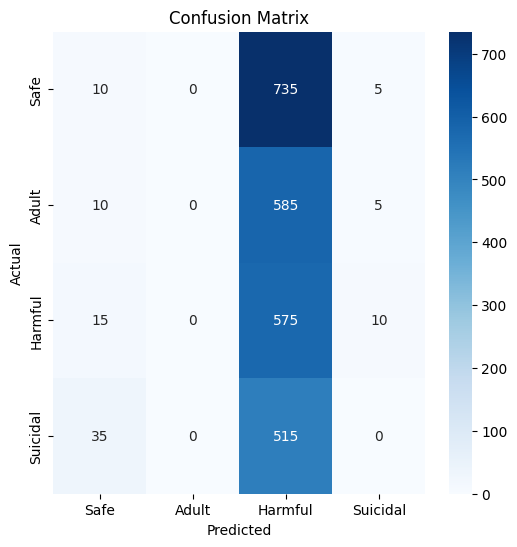

In [49]:
cm = confusion_matrix(y, y_pred_labels)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=uniques, yticklabels=uniques)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()